# Imports & basic configuration

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from branch.galerkin import DGMNet
from branch.bsde import BSDENet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.13.1+cu117


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Thu Apr 27 18:13:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    On   | 00000000:21:00.0  On |                  Off |
| 41%   45C    P8    21W / 140W |   3683MiB / 16376MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    disable_relative=False,
    **kwargs,
):
    if not os.path.isdir('logs/deep_branching/data/'):
        os.makedirs('logs/deep_branching/data/')
    if not os.path.isdir('logs/deep_branching/plot/'):
        os.makedirs('logs/deep_branching/plot/')
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)
    
    problem_name = fname
    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, problem_name=problem_name, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            # note that branch output batch_size x 1 instead of batch_size like other algo
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device), patch=model.patches - 1)[:, 0].detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                branch_rel_error.append(0)
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                dgm_rel_error.append(0)
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                bsde_rel_error.append(0)
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "logs/deep_branching/data/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"logs/deep_branching/plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "logs/deep_branching/data/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

In [5]:
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return ( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) 
    
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return (( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) + dim * dim * y[(dim+1):(2*dim+1)].sum(dim=0) / 2 )

def phi_example(x, coordinate=0):
    return torch.exp( T + x.sum(axis=0) / dim ) / (1 + torch.exp( T + x.sum(axis=0) / dim ) )
        
def exact_example(t, x, T):
    xi = t + x.sum(axis=0) / dim 
    return 1 / (1 + np.exp( - xi ) )

t_lo, x_lo, x_hi = 0., -5., 5.
    
x_mid = (x_lo + x_hi) / 2
grid = np.linspace(x_lo, x_hi, 100)

T = 0.1
dim = 10
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 111 seconds; L1 error: 5.40E-04; L2 error: 5.44E-07; rel error: 1.11E-03.
fdb runtime: 137 seconds; total runtime: 248 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 335 seconds; L1 error: 2.07E-03; L2 error: 5.30E-06; rel error: 3.93E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 148 seconds; L1 error: 7.36E-04; L2 error: 8.62E-07; rel error: 1.45E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 9.43E-04; L2 error: 1.62E-06; rel error: 1.93E-03.
fdb runtime: 102 seconds; total runtime: 222 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 332 seconds; L1 error: 6.15E-03; L2 error: 4.02E-05; rel error: 1.21E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 141 seconds; L1 error: 4.99E-04; L2 error: 3.61E-07; rel error: 1.03E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 6.57E-04; L2 error: 7.71E-07; rel error: 1.36E-03.
fdb runtime: 109 seconds; total runtime: 229 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 335 seconds; L1 error: 1.53E-03; L2 error: 2.66E-06; rel error: 3.29E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 145 seconds; L1 error: 4.97E-04; L2 error: 3.28E-07; rel error: 1.01E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 122 seconds; L1 error: 6.10E-04; L2 error: 5.96E-07; rel error: 1.25E-03.
fdb runtime: 170 seconds; total runtime: 292 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 340 seconds; L1 error: 4.68E-03; L2 error: 2.49E-05; rel error: 9.06E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 147 seconds; L1 error: 8.93E-04; L2 error: 1.25E-06; rel error: 1.84E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 4.87E-04; L2 error: 3.58E-07; rel error: 1.03E-03.
fdb runtime: 258 seconds; total runtime: 382 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 339 seconds; L1 error: 2.91E-04; L2 error: 1.34E-07; rel error: 6.32E-04.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 149 seconds; L1 error: 6.03E-04; L2 error: 5.66E-07; rel error: 1.31E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 113 seconds; L1 error: 5.11E-04; L2 error: 3.89E-07; rel error: 1.00E-03.
fdb runtime: 121 seconds; total runtime: 234 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 339 seconds; L1 error: 3.64E-03; L2 error: 1.69E-05; rel error: 7.30E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 143 seconds; L1 error: 1.17E-03; L2 error: 2.17E-06; rel error: 2.25E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 6.14E-04; L2 error: 8.32E-07; rel error: 1.26E-03.
fdb runtime: 116 seconds; total runtime: 237 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 341 seconds; L1 error: 2.61E-03; L2 error: 9.79E-06; rel error: 4.82E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 152 seconds; L1 error: 1.00E-03; L2 error: 1.68E-06; rel error: 1.92E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 108 seconds; L1 error: 6.01E-04; L2 error: 5.53E-07; rel error: 1.20E-03.
fdb runtime: 114 seconds; total runtime: 223 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 349 seconds; L1 error: 4.85E-03; L2 error: 2.80E-05; rel error: 9.32E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 145 seconds; L1 error: 6.97E-04; L2 error: 8.35E-07; rel error: 1.42E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 6.18E-04; L2 error: 7.60E-07; rel error: 1.26E-03.
fdb runtime: 162 seconds; total runtime: 285 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 334 seconds; L1 error: 7.25E-04; L2 error: 9.79E-07; rel error: 1.68E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 145 seconds; L1 error: 1.64E-03; L2 error: 2.95E-06; rel error: 3.42E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 118 seconds; L1 error: 9.66E-04; L2 error: 1.31E-06; rel error: 1.98E-03.
fdb runtime: 145 seconds; total runtime: 263 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 331 seconds; L1 error: 4.68E-02; L2 error: 2.90E-03; rel error: 9.70E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 136 seconds; L1 error: 6.29E-04; L2 error: 5.88E-07; rel error: 1.24E-03.




######## Summary for deep branching method
runtime:        118
fdb runtime:    143
total runtime:  261
mean L1 error:  6.55E-04
std L1 error:   1.58E-04
mean L2 error:  7.73E-07
std L2 error:   3.81E-07
mean rel error: 1.34E-03
std rel error:  3.25E-04


######## Summary for deep galerkin method
runtime:        337
mean L1 error:  7.33E-03
std L1 error:   1.33E-02
mean L2 error:  3.03E-04
std L2 error:   8.65E-04
mean rel error: 1.49E-02
std rel error:  2.76E-02


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  8.37E-04


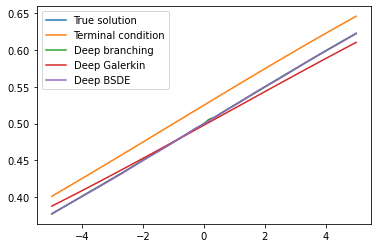

In [6]:
T=0.0001
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 107 seconds; L1 error: 8.21E-04; L2 error: 1.17E-06; rel error: 1.59E-03.
fdb runtime: 133 seconds; total runtime: 239 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 333 seconds; L1 error: 1.80E-03; L2 error: 4.11E-06; rel error: 3.41E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 143 seconds; L1 error: 8.00E-04; L2 error: 8.73E-07; rel error: 1.68E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 1.12E-03; L2 error: 2.39E-06; rel error: 2.29E-03.
fdb runtime: 101 seconds; total runtime: 218 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 342 seconds; L1 error: 5.11E-03; L2 error: 2.86E-05; rel error: 1.00E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 141 seconds; L1 error: 4.88E-04; L2 error: 3.61E-07; rel error: 1.05E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 118 seconds; L1 error: 6.15E-04; L2 error: 6.04E-07; rel error: 1.29E-03.
fdb runtime: 108 seconds; total runtime: 227 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 327 seconds; L1 error: 1.27E-03; L2 error: 1.92E-06; rel error: 2.75E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 144 seconds; L1 error: 7.69E-04; L2 error: 8.47E-07; rel error: 1.49E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 8.66E-04; L2 error: 1.36E-06; rel error: 1.72E-03.
fdb runtime: 167 seconds; total runtime: 286 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 338 seconds; L1 error: 4.08E-03; L2 error: 1.97E-05; rel error: 7.83E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 148 seconds; L1 error: 1.21E-03; L2 error: 2.04E-06; rel error: 2.52E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 126 seconds; L1 error: 5.61E-04; L2 error: 5.08E-07; rel error: 1.12E-03.
fdb runtime: 263 seconds; total runtime: 389 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 319 seconds; L1 error: 3.14E-04; L2 error: 1.70E-07; rel error: 6.79E-04.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 143 seconds; L1 error: 9.35E-04; L2 error: 1.27E-06; rel error: 1.99E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 5.75E-04; L2 error: 4.75E-07; rel error: 1.17E-03.
fdb runtime: 123 seconds; total runtime: 242 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 336 seconds; L1 error: 3.55E-03; L2 error: 1.62E-05; rel error: 7.23E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 139 seconds; L1 error: 7.86E-04; L2 error: 1.20E-06; rel error: 1.54E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 1.01E-03; L2 error: 1.61E-06; rel error: 2.01E-03.
fdb runtime: 115 seconds; total runtime: 225 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 340 seconds; L1 error: 2.41E-03; L2 error: 8.74E-06; rel error: 4.42E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 140 seconds; L1 error: 7.15E-04; L2 error: 7.08E-07; rel error: 1.44E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 106 seconds; L1 error: 7.22E-04; L2 error: 7.15E-07; rel error: 1.50E-03.
fdb runtime: 117 seconds; total runtime: 223 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 324 seconds; L1 error: 4.09E-03; L2 error: 2.02E-05; rel error: 7.83E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 144 seconds; L1 error: 7.45E-04; L2 error: 8.97E-07; rel error: 1.57E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 6.94E-04; L2 error: 9.72E-07; rel error: 1.42E-03.
fdb runtime: 166 seconds; total runtime: 287 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 328 seconds; L1 error: 6.83E-04; L2 error: 8.34E-07; rel error: 1.57E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 143 seconds; L1 error: 1.13E-03; L2 error: 1.88E-06; rel error: 2.46E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 122 seconds; L1 error: 8.66E-04; L2 error: 9.93E-07; rel error: 1.81E-03.
fdb runtime: 152 seconds; total runtime: 274 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 341 seconds; L1 error: 4.67E-02; L2 error: 2.89E-03; rel error: 9.73E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 141 seconds; L1 error: 9.43E-04; L2 error: 1.21E-06; rel error: 1.94E-03.




######## Summary for deep branching method
runtime:        116
fdb runtime:    145
total runtime:  261
mean L1 error:  7.85E-04
std L1 error:   1.76E-04
mean L2 error:  1.08E-06
std L2 error:   5.61E-07
mean rel error: 1.59E-03
std rel error:  3.55E-04


######## Summary for deep galerkin method
runtime:        333
mean L1 error:  7.00E-03
std L1 error:   1.33E-02
mean L2 error:  3.00E-04
std L2 error:   8.65E-04
mean rel error: 1.43E-02
std rel error:  2.78E-02


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  8.51E-04


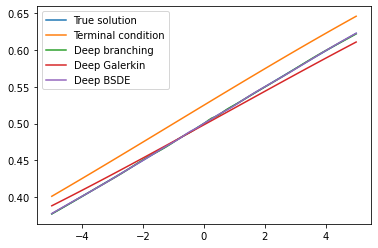

In [7]:
T=0.0125
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 109 seconds; L1 error: 9.31E-04; L2 error: 1.24E-06; rel error: 1.93E-03.
fdb runtime: 138 seconds; total runtime: 247 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 334 seconds; L1 error: 1.55E-03; L2 error: 3.05E-06; rel error: 2.93E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 145 seconds; L1 error: 1.23E-03; L2 error: 2.17E-06; rel error: 2.49E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 1.21E-03; L2 error: 2.90E-06; rel error: 2.53E-03.
fdb runtime: 104 seconds; total runtime: 222 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 329 seconds; L1 error: 4.08E-03; L2 error: 1.91E-05; rel error: 7.90E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 143 seconds; L1 error: 5.40E-04; L2 error: 4.66E-07; rel error: 1.14E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 122 seconds; L1 error: 8.37E-04; L2 error: 1.63E-06; rel error: 1.72E-03.
fdb runtime: 109 seconds; total runtime: 231 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 333 seconds; L1 error: 1.03E-03; L2 error: 1.36E-06; rel error: 2.26E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 140 seconds; L1 error: 9.20E-04; L2 error: 1.20E-06; rel error: 1.82E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 1.06E-03; L2 error: 2.01E-06; rel error: 2.27E-03.
fdb runtime: 169 seconds; total runtime: 288 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 328 seconds; L1 error: 3.49E-03; L2 error: 1.51E-05; rel error: 6.62E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 150 seconds; L1 error: 1.22E-03; L2 error: 2.05E-06; rel error: 2.41E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 1.07E-03; L2 error: 1.81E-06; rel error: 2.33E-03.
fdb runtime: 250 seconds; total runtime: 370 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 343 seconds; L1 error: 3.61E-04; L2 error: 2.30E-07; rel error: 7.75E-04.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 142 seconds; L1 error: 9.52E-04; L2 error: 1.20E-06; rel error: 1.91E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 115 seconds; L1 error: 7.73E-04; L2 error: 1.25E-06; rel error: 1.61E-03.
fdb runtime: 120 seconds; total runtime: 235 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 335 seconds; L1 error: 3.49E-03; L2 error: 1.59E-05; rel error: 7.21E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 147 seconds; L1 error: 9.32E-04; L2 error: 1.29E-06; rel error: 1.90E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 8.10E-04; L2 error: 1.19E-06; rel error: 1.73E-03.
fdb runtime: 119 seconds; total runtime: 242 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 338 seconds; L1 error: 2.22E-03; L2 error: 7.76E-06; rel error: 4.06E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 145 seconds; L1 error: 7.36E-04; L2 error: 8.17E-07; rel error: 1.41E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 112 seconds; L1 error: 1.17E-03; L2 error: 2.63E-06; rel error: 2.62E-03.
fdb runtime: 116 seconds; total runtime: 227 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 338 seconds; L1 error: 3.40E-03; L2 error: 1.39E-05; rel error: 6.54E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 145 seconds; L1 error: 6.46E-04; L2 error: 6.39E-07; rel error: 1.25E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 124 seconds; L1 error: 1.04E-03; L2 error: 2.01E-06; rel error: 2.15E-03.
fdb runtime: 169 seconds; total runtime: 293 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 339 seconds; L1 error: 6.61E-04; L2 error: 7.38E-07; rel error: 1.51E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 146 seconds; L1 error: 8.78E-04; L2 error: 1.16E-06; rel error: 1.91E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 1.34E-03; L2 error: 2.95E-06; rel error: 2.67E-03.
fdb runtime: 147 seconds; total runtime: 267 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 337 seconds; L1 error: 4.67E-02; L2 error: 2.90E-03; rel error: 9.78E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 144 seconds; L1 error: 1.25E-03; L2 error: 2.09E-06; rel error: 2.43E-03.




######## Summary for deep branching method
runtime:        118
fdb runtime:    144
total runtime:  262
mean L1 error:  1.03E-03
std L1 error:   1.78E-04
mean L2 error:  1.96E-06
std L2 error:   6.37E-07
mean rel error: 2.15E-03
std rel error:  3.70E-04


######## Summary for deep galerkin method
runtime:        335
mean L1 error:  6.70E-03
std L1 error:   1.34E-02
mean L2 error:  2.98E-04
std L2 error:   8.67E-04
mean rel error: 1.38E-02
std rel error:  2.81E-02


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  9.30E-04


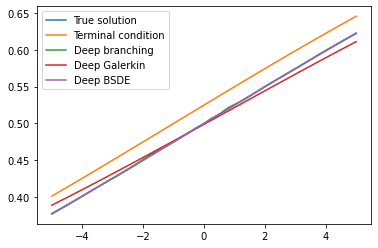

In [8]:
T=0.0250
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 1.28E-03; L2 error: 2.44E-06; rel error: 2.64E-03.
fdb runtime: 135 seconds; total runtime: 245 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 334 seconds; L1 error: 1.31E-03; L2 error: 2.20E-06; rel error: 2.50E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 145 seconds; L1 error: 4.73E-04; L2 error: 3.69E-07; rel error: 9.78E-04.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 1.64E-03; L2 error: 4.85E-06; rel error: 3.61E-03.
fdb runtime: 105 seconds; total runtime: 222 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 329 seconds; L1 error: 3.11E-03; L2 error: 1.18E-05; rel error: 5.96E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 143 seconds; L1 error: 9.67E-04; L2 error: 1.31E-06; rel error: 1.96E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 1.52E-03; L2 error: 6.60E-06; rel error: 3.20E-03.
fdb runtime: 111 seconds; total runtime: 228 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 334 seconds; L1 error: 8.14E-04; L2 error: 9.50E-07; rel error: 1.81E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 148 seconds; L1 error: 1.39E-03; L2 error: 2.87E-06; rel error: 2.65E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 1.62E-03; L2 error: 4.87E-06; rel error: 3.49E-03.
fdb runtime: 171 seconds; total runtime: 293 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 329 seconds; L1 error: 2.96E-03; L2 error: 1.12E-05; rel error: 5.59E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 141 seconds; L1 error: 7.53E-04; L2 error: 8.02E-07; rel error: 1.51E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 1.57E-03; L2 error: 4.09E-06; rel error: 3.46E-03.
fdb runtime: 257 seconds; total runtime: 377 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 331 seconds; L1 error: 4.39E-04; L2 error: 3.10E-07; rel error: 9.33E-04.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 146 seconds; L1 error: 1.13E-03; L2 error: 2.22E-06; rel error: 2.30E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 1.60E-03; L2 error: 4.48E-06; rel error: 3.48E-03.
fdb runtime: 121 seconds; total runtime: 232 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 336 seconds; L1 error: 3.46E-03; L2 error: 1.60E-05; rel error: 7.27E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 141 seconds; L1 error: 9.26E-04; L2 error: 1.12E-06; rel error: 1.95E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 115 seconds; L1 error: 1.31E-03; L2 error: 2.73E-06; rel error: 2.77E-03.
fdb runtime: 115 seconds; total runtime: 230 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 346 seconds; L1 error: 2.05E-03; L2 error: 6.85E-06; rel error: 3.74E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 145 seconds; L1 error: 1.08E-03; L2 error: 1.84E-06; rel error: 2.35E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 109 seconds; L1 error: 1.97E-03; L2 error: 1.04E-05; rel error: 4.55E-03.
fdb runtime: 116 seconds; total runtime: 225 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 340 seconds; L1 error: 2.81E-03; L2 error: 9.35E-06; rel error: 5.49E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 137 seconds; L1 error: 1.23E-03; L2 error: 2.07E-06; rel error: 2.55E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 118 seconds; L1 error: 2.17E-03; L2 error: 1.07E-05; rel error: 4.46E-03.
fdb runtime: 170 seconds; total runtime: 288 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 337 seconds; L1 error: 6.53E-04; L2 error: 6.85E-07; rel error: 1.48E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 142 seconds; L1 error: 1.46E-03; L2 error: 2.98E-06; rel error: 3.08E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 1.62E-03; L2 error: 6.58E-06; rel error: 3.12E-03.
fdb runtime: 146 seconds; total runtime: 263 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 341 seconds; L1 error: 4.67E-02; L2 error: 2.91E-03; rel error: 9.83E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 150 seconds; L1 error: 1.46E-03; L2 error: 2.82E-06; rel error: 3.00E-03.




######## Summary for deep branching method
runtime:        115
fdb runtime:    145
total runtime:  260
mean L1 error:  1.63E-03
std L1 error:   2.55E-04
mean L2 error:  5.78E-06
std L2 error:   2.72E-06
mean rel error: 3.48E-03
std rel error:  5.95E-04


######## Summary for deep galerkin method
runtime:        336
mean L1 error:  6.43E-03
std L1 error:   1.35E-02
mean L2 error:  2.97E-04
std L2 error:   8.71E-04
mean rel error: 1.33E-02
std rel error:  2.84E-02


######## Summary for deep BSDE method
runtime:        144
mean L1 error:  1.09E-03


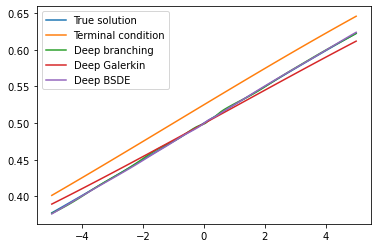

In [9]:
T=0.0375
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 1.95E-03; L2 error: 5.64E-06; rel error: 4.05E-03.
fdb runtime: 132 seconds; total runtime: 243 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 330 seconds; L1 error: 1.10E-03; L2 error: 1.60E-06; rel error: 2.17E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 143 seconds; L1 error: 1.23E-03; L2 error: 2.18E-06; rel error: 2.62E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 2.78E-03; L2 error: 1.62E-05; rel error: 6.36E-03.
fdb runtime: 101 seconds; total runtime: 218 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 332 seconds; L1 error: 2.32E-03; L2 error: 6.61E-06; rel error: 4.47E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 148 seconds; L1 error: 8.79E-04; L2 error: 1.24E-06; rel error: 1.88E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 2.45E-03; L2 error: 1.73E-05; rel error: 5.13E-03.
fdb runtime: 107 seconds; total runtime: 226 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 327 seconds; L1 error: 6.23E-04; L2 error: 6.73E-07; rel error: 1.42E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 143 seconds; L1 error: 1.54E-03; L2 error: 3.02E-06; rel error: 3.05E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 126 seconds; L1 error: 1.44E-03; L2 error: 3.41E-06; rel error: 3.10E-03.
fdb runtime: 163 seconds; total runtime: 289 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 332 seconds; L1 error: 2.51E-03; L2 error: 8.04E-06; rel error: 4.76E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 142 seconds; L1 error: 2.46E-03; L2 error: 7.15E-06; rel error: 5.03E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 2.51E-03; L2 error: 1.02E-05; rel error: 5.49E-03.
fdb runtime: 256 seconds; total runtime: 373 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 320 seconds; L1 error: 5.39E-04; L2 error: 4.06E-07; rel error: 1.14E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 147 seconds; L1 error: 5.64E-04; L2 error: 5.69E-07; rel error: 1.14E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 2.46E-03; L2 error: 8.89E-06; rel error: 5.11E-03.
fdb runtime: 118 seconds; total runtime: 227 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 325 seconds; L1 error: 3.46E-03; L2 error: 1.67E-05; rel error: 7.39E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 142 seconds; L1 error: 9.84E-04; L2 error: 1.63E-06; rel error: 2.14E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 1.76E-03; L2 error: 5.10E-06; rel error: 3.80E-03.
fdb runtime: 112 seconds; total runtime: 233 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 335 seconds; L1 error: 1.90E-03; L2 error: 6.03E-06; rel error: 3.47E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 145 seconds; L1 error: 1.20E-03; L2 error: 2.03E-06; rel error: 2.44E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 105 seconds; L1 error: 3.16E-03; L2 error: 3.02E-05; rel error: 7.40E-03.
fdb runtime: 111 seconds; total runtime: 217 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 333 seconds; L1 error: 2.33E-03; L2 error: 6.51E-06; rel error: 4.71E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 135 seconds; L1 error: 9.80E-04; L2 error: 1.69E-06; rel error: 1.93E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 3.74E-03; L2 error: 3.59E-05; rel error: 7.68E-03.
fdb runtime: 160 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 327 seconds; L1 error: 6.55E-04; L2 error: 6.68E-07; rel error: 1.47E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 144 seconds; L1 error: 1.22E-03; L2 error: 1.98E-06; rel error: 2.47E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 118 seconds; L1 error: 2.97E-03; L2 error: 2.11E-05; rel error: 5.65E-03.
fdb runtime: 147 seconds; total runtime: 266 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 339 seconds; L1 error: 4.68E-02; L2 error: 2.93E-03; rel error: 9.89E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 144 seconds; L1 error: 1.45E-03; L2 error: 3.16E-06; rel error: 3.05E-03.




######## Summary for deep branching method
runtime:        116
fdb runtime:    141
total runtime:  257
mean L1 error:  2.52E-03
std L1 error:   6.53E-04
mean L2 error:  1.54E-05
std L2 error:   1.05E-05
mean rel error: 5.38E-03
std rel error:  1.41E-03


######## Summary for deep galerkin method
runtime:        330
mean L1 error:  6.23E-03
std L1 error:   1.36E-02
mean L2 error:  2.97E-04
std L2 error:   8.77E-04
mean rel error: 1.30E-02
std rel error:  2.87E-02


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  1.25E-03


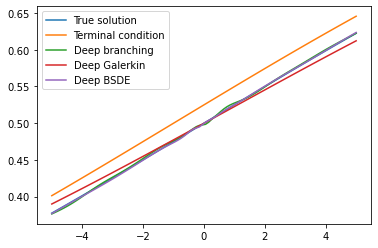

In [10]:
T=0.0500
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 109 seconds; L1 error: 2.77E-03; L2 error: 1.21E-05; rel error: 5.66E-03.
fdb runtime: 141 seconds; total runtime: 250 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 330 seconds; L1 error: 9.65E-04; L2 error: 1.33E-06; rel error: 1.99E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 142 seconds; L1 error: 9.67E-04; L2 error: 1.18E-06; rel error: 1.96E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 2.56E-03; L2 error: 1.09E-05; rel error: 5.64E-03.
fdb runtime: 104 seconds; total runtime: 224 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 327 seconds; L1 error: 1.73E-03; L2 error: 3.53E-06; rel error: 3.44E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 143 seconds; L1 error: 9.76E-04; L2 error: 1.50E-06; rel error: 2.01E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 3.23E-03; L2 error: 1.45E-05; rel error: 6.80E-03.
fdb runtime: 109 seconds; total runtime: 226 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 339 seconds; L1 error: 4.99E-04; L2 error: 4.97E-07; rel error: 1.16E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 149 seconds; L1 error: 1.52E-03; L2 error: 3.99E-06; rel error: 2.95E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 2.29E-03; L2 error: 8.20E-06; rel error: 4.94E-03.
fdb runtime: 169 seconds; total runtime: 290 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 326 seconds; L1 error: 2.14E-03; L2 error: 5.64E-06; rel error: 4.14E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 143 seconds; L1 error: 2.02E-03; L2 error: 5.77E-06; rel error: 3.98E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 127 seconds; L1 error: 3.29E-03; L2 error: 1.47E-05; rel error: 7.00E-03.
fdb runtime: 257 seconds; total runtime: 384 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 328 seconds; L1 error: 6.32E-04; L2 error: 5.13E-07; rel error: 1.33E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 147 seconds; L1 error: 9.32E-04; L2 error: 1.89E-06; rel error: 1.94E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 111 seconds; L1 error: 3.31E-03; L2 error: 1.57E-05; rel error: 6.94E-03.
fdb runtime: 122 seconds; total runtime: 233 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 330 seconds; L1 error: 3.49E-03; L2 error: 1.78E-05; rel error: 7.58E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 139 seconds; L1 error: 1.31E-03; L2 error: 2.66E-06; rel error: 2.70E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 2.35E-03; L2 error: 8.49E-06; rel error: 5.11E-03.
fdb runtime: 112 seconds; total runtime: 228 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 317 seconds; L1 error: 1.77E-03; L2 error: 5.30E-06; rel error: 3.26E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 142 seconds; L1 error: 1.53E-03; L2 error: 3.09E-06; rel error: 3.26E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 112 seconds; L1 error: 2.60E-03; L2 error: 1.19E-05; rel error: 5.74E-03.
fdb runtime: 112 seconds; total runtime: 224 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 328 seconds; L1 error: 1.99E-03; L2 error: 5.48E-06; rel error: 4.24E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 146 seconds; L1 error: 1.11E-03; L2 error: 2.08E-06; rel error: 2.14E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 2.29E-03; L2 error: 8.40E-06; rel error: 4.75E-03.
fdb runtime: 159 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 341 seconds; L1 error: 6.62E-04; L2 error: 6.81E-07; rel error: 1.49E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 149 seconds; L1 error: 1.47E-03; L2 error: 2.72E-06; rel error: 3.02E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 3.42E-03; L2 error: 5.22E-05; rel error: 6.76E-03.
fdb runtime: 142 seconds; total runtime: 258 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 332 seconds; L1 error: 4.69E-02; L2 error: 2.95E-03; rel error: 9.96E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 149 seconds; L1 error: 2.31E-03; L2 error: 6.21E-06; rel error: 4.66E-03.




######## Summary for deep branching method
runtime:        117
fdb runtime:    143
total runtime:  260
mean L1 error:  2.81E-03
std L1 error:   4.34E-04
mean L2 error:  1.57E-05
std L2 error:   1.24E-05
mean rel error: 5.93E-03
std rel error:  8.28E-04


######## Summary for deep galerkin method
runtime:        330
mean L1 error:  6.08E-03
std L1 error:   1.36E-02
mean L2 error:  2.99E-04
std L2 error:   8.85E-04
mean rel error: 1.28E-02
std rel error:  2.90E-02


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  1.41E-03


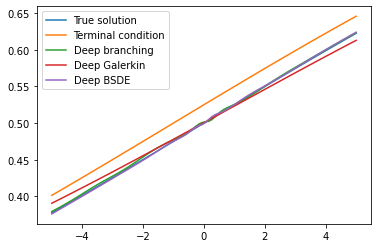

In [11]:
T=0.0625
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 107 seconds; L1 error: 3.76E-03; L2 error: 2.34E-05; rel error: 7.62E-03.
fdb runtime: 129 seconds; total runtime: 237 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 316 seconds; L1 error: 9.32E-04; L2 error: 1.44E-06; rel error: 2.04E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 149 seconds; L1 error: 2.80E-03; L2 error: 1.00E-05; rel error: 5.75E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 3.65E-03; L2 error: 2.13E-05; rel error: 8.04E-03.
fdb runtime: 99 seconds; total runtime: 220 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 342 seconds; L1 error: 1.35E-03; L2 error: 2.53E-06; rel error: 2.90E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 149 seconds; L1 error: 2.01E-03; L2 error: 6.86E-06; rel error: 4.29E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 4.41E-03; L2 error: 2.63E-05; rel error: 9.21E-03.
fdb runtime: 107 seconds; total runtime: 223 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 325 seconds; L1 error: 4.54E-04; L2 error: 3.93E-07; rel error: 1.05E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 148 seconds; L1 error: 2.57E-03; L2 error: 7.99E-06; rel error: 5.10E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 3.60E-03; L2 error: 2.00E-05; rel error: 7.62E-03.
fdb runtime: 163 seconds; total runtime: 282 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 336 seconds; L1 error: 1.86E-03; L2 error: 4.13E-06; rel error: 3.72E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 147 seconds; L1 error: 2.74E-03; L2 error: 1.11E-05; rel error: 5.71E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 4.30E-03; L2 error: 2.82E-05; rel error: 9.40E-03.
fdb runtime: 250 seconds; total runtime: 373 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 344 seconds; L1 error: 7.19E-04; L2 error: 6.29E-07; rel error: 1.51E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 143 seconds; L1 error: 2.79E-03; L2 error: 1.17E-05; rel error: 5.65E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 4.31E-03; L2 error: 2.78E-05; rel error: 8.81E-03.
fdb runtime: 119 seconds; total runtime: 239 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 330 seconds; L1 error: 3.56E-03; L2 error: 1.95E-05; rel error: 7.86E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 144 seconds; L1 error: 1.50E-03; L2 error: 2.77E-06; rel error: 3.16E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 113 seconds; L1 error: 3.08E-03; L2 error: 1.52E-05; rel error: 6.75E-03.
fdb runtime: 112 seconds; total runtime: 225 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 338 seconds; L1 error: 1.68E-03; L2 error: 4.66E-06; rel error: 3.11E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 144 seconds; L1 error: 1.36E-03; L2 error: 2.63E-06; rel error: 3.01E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 113 seconds; L1 error: 3.48E-03; L2 error: 2.21E-05; rel error: 7.69E-03.
fdb runtime: 112 seconds; total runtime: 225 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 317 seconds; L1 error: 1.83E-03; L2 error: 6.32E-06; rel error: 4.15E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 151 seconds; L1 error: 1.09E-03; L2 error: 2.11E-06; rel error: 2.20E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 3.11E-03; L2 error: 1.61E-05; rel error: 6.42E-03.
fdb runtime: 159 seconds; total runtime: 276 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 326 seconds; L1 error: 6.74E-04; L2 error: 7.24E-07; rel error: 1.52E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 146 seconds; L1 error: 2.28E-03; L2 error: 6.96E-06; rel error: 4.63E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 2.01E-03; L2 error: 5.63E-06; rel error: 4.18E-03.
fdb runtime: 142 seconds; total runtime: 265 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 329 seconds; L1 error: 4.71E-02; L2 error: 2.99E-03; rel error: 1.00E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 146 seconds; L1 error: 3.14E-03; L2 error: 1.32E-05; rel error: 6.31E-03.




######## Summary for deep branching method
runtime:        117
fdb runtime:    139
total runtime:  257
mean L1 error:  3.57E-03
std L1 error:   6.88E-04
mean L2 error:  2.06E-05
std L2 error:   6.52E-06
mean rel error: 7.58E-03
std rel error:  1.46E-03


######## Summary for deep galerkin method
runtime:        330
mean L1 error:  6.02E-03
std L1 error:   1.37E-02
mean L2 error:  3.03E-04
std L2 error:   8.95E-04
mean rel error: 1.28E-02
std rel error:  2.92E-02


######## Summary for deep BSDE method
runtime:        147
mean L1 error:  2.23E-03


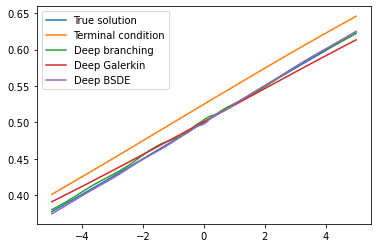

In [12]:
T=0.0750
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 109 seconds; L1 error: 4.84E-03; L2 error: 4.15E-05; rel error: 9.78E-03.
fdb runtime: 129 seconds; total runtime: 238 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 312 seconds; L1 error: 1.07E-03; L2 error: 2.03E-06; rel error: 2.43E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 149 seconds; L1 error: 2.77E-03; L2 error: 1.17E-05; rel error: 5.84E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 115 seconds; L1 error: 4.81E-03; L2 error: 3.69E-05; rel error: 1.06E-02.
fdb runtime: 100 seconds; total runtime: 214 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 331 seconds; L1 error: 1.26E-03; L2 error: 3.57E-06; rel error: 2.97E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 143 seconds; L1 error: 2.92E-03; L2 error: 1.32E-05; rel error: 6.20E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 118 seconds; L1 error: 5.49E-03; L2 error: 4.21E-05; rel error: 1.15E-02.
fdb runtime: 106 seconds; total runtime: 224 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 326 seconds; L1 error: 4.44E-04; L2 error: 3.41E-07; rel error: 1.01E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 3.39E-03; L2 error: 1.38E-05; rel error: 7.01E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 4.33E-03; L2 error: 3.23E-05; rel error: 9.42E-03.
fdb runtime: 163 seconds; total runtime: 283 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 331 seconds; L1 error: 1.68E-03; L2 error: 3.56E-06; rel error: 3.52E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 150 seconds; L1 error: 4.05E-03; L2 error: 2.54E-05; rel error: 8.06E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 5.62E-03; L2 error: 5.01E-05; rel error: 1.24E-02.
fdb runtime: 251 seconds; total runtime: 368 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 339 seconds; L1 error: 8.02E-04; L2 error: 7.54E-07; rel error: 1.68E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 143 seconds; L1 error: 2.51E-03; L2 error: 9.45E-06; rel error: 5.39E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 4.77E-03; L2 error: 3.44E-05; rel error: 1.00E-02.
fdb runtime: 119 seconds; total runtime: 235 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 335 seconds; L1 error: 3.68E-03; L2 error: 2.18E-05; rel error: 8.24E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 142 seconds; L1 error: 3.66E-03; L2 error: 1.54E-05; rel error: 7.62E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 112 seconds; L1 error: 3.87E-03; L2 error: 2.59E-05; rel error: 8.57E-03.
fdb runtime: 112 seconds; total runtime: 224 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 336 seconds; L1 error: 1.61E-03; L2 error: 4.14E-06; rel error: 3.04E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 143 seconds; L1 error: 2.55E-03; L2 error: 8.17E-06; rel error: 5.32E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 111 seconds; L1 error: 4.44E-03; L2 error: 3.70E-05; rel error: 9.82E-03.
fdb runtime: 112 seconds; total runtime: 223 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 321 seconds; L1 error: 1.94E-03; L2 error: 9.11E-06; rel error: 4.62E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 150 seconds; L1 error: 3.91E-03; L2 error: 1.88E-05; rel error: 7.95E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 4.21E-03; L2 error: 2.92E-05; rel error: 8.71E-03.
fdb runtime: 160 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 342 seconds; L1 error: 6.90E-04; L2 error: 8.03E-07; rel error: 1.57E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 149 seconds; L1 error: 2.85E-03; L2 error: 1.13E-05; rel error: 5.62E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 2.57E-03; L2 error: 9.34E-06; rel error: 5.16E-03.
fdb runtime: 143 seconds; total runtime: 259 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 332 seconds; L1 error: 4.73E-02; L2 error: 3.03E-03; rel error: 1.01E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 145 seconds; L1 error: 2.35E-03; L2 error: 8.12E-06; rel error: 4.63E-03.




######## Summary for deep branching method
runtime:        115
fdb runtime:    140
total runtime:  255
mean L1 error:  4.50E-03
std L1 error:   8.21E-04
mean L2 error:  3.39E-05
std L2 error:   1.05E-05
mean rel error: 9.59E-03
std rel error:  1.85E-03


######## Summary for deep galerkin method
runtime:        330
mean L1 error:  6.05E-03
std L1 error:   1.38E-02
mean L2 error:  3.08E-04
std L2 error:   9.08E-04
mean rel error: 1.30E-02
std rel error:  2.95E-02


######## Summary for deep BSDE method
runtime:        146
mean L1 error:  3.10E-03


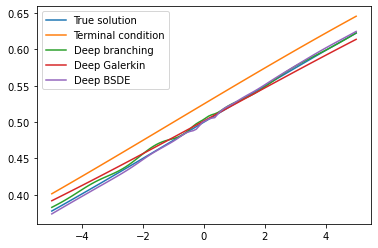

In [13]:
T=0.0875
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 111 seconds; L1 error: 6.33E-03; L2 error: 6.16E-05; rel error: 1.29E-02.
fdb runtime: 130 seconds; total runtime: 241 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 328 seconds; L1 error: 1.39E-03; L2 error: 3.18E-06; rel error: 3.17E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 148 seconds; L1 error: 3.00E-03; L2 error: 1.25E-05; rel error: 5.91E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 6.17E-03; L2 error: 6.12E-05; rel error: 1.36E-02.
fdb runtime: 99 seconds; total runtime: 220 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 325 seconds; L1 error: 2.02E-03; L2 error: 6.65E-06; rel error: 4.58E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 148 seconds; L1 error: 2.51E+01; L2 error: 8.00E+02; rel error: 5.41E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 118 seconds; L1 error: 6.77E-03; L2 error: 6.54E-05; rel error: 1.41E-02.
fdb runtime: 107 seconds; total runtime: 224 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 322 seconds; L1 error: 4.53E-04; L2 error: 3.21E-07; rel error: 1.01E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 3.04E-03; L2 error: 1.20E-05; rel error: 6.14E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 122 seconds; L1 error: 5.74E-03; L2 error: 5.75E-05; rel error: 1.24E-02.
fdb runtime: 163 seconds; total runtime: 286 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 337 seconds; L1 error: 1.60E-03; L2 error: 4.05E-06; rel error: 3.55E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 133 seconds; L1 error: 2.17E+01; L2 error: 4.93E+02; rel error: 4.53E+01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 7.29E-03; L2 error: 9.21E-05; rel error: 1.62E-02.
fdb runtime: 251 seconds; total runtime: 367 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 330 seconds; L1 error: 8.81E-04; L2 error: 8.85E-07; rel error: 1.84E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 146 seconds; L1 error: 9.55E-03; L2 error: 1.24E-04; rel error: 1.95E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 5.88E-03; L2 error: 5.24E-05; rel error: 1.24E-02.
fdb runtime: 119 seconds; total runtime: 236 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 317 seconds; L1 error: 3.86E-03; L2 error: 2.50E-05; rel error: 8.75E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 147 seconds; L1 error: 4.07E-03; L2 error: 2.52E-05; rel error: 8.57E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 5.20E-03; L2 error: 4.28E-05; rel error: 1.14E-02.
fdb runtime: 113 seconds; total runtime: 232 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 332 seconds; L1 error: 1.57E-03; L2 error: 3.74E-06; rel error: 3.04E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 150 seconds; L1 error: 2.96E-03; L2 error: 1.25E-05; rel error: 6.18E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 5.12E-03; L2 error: 4.65E-05; rel error: 1.11E-02.
fdb runtime: 112 seconds; total runtime: 222 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 319 seconds; L1 error: 2.85E-03; L2 error: 1.39E-05; rel error: 6.52E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 151 seconds; L1 error: 5.57E-03; L2 error: 5.11E-05; rel error: 1.14E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 5.55E-03; L2 error: 4.79E-05; rel error: 1.15E-02.
fdb runtime: 159 seconds; total runtime: 278 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 347 seconds; L1 error: 7.15E-04; L2 error: 9.32E-07; rel error: 1.65E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 145 seconds; L1 error: 3.49E-03; L2 error: 1.55E-05; rel error: 7.35E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 3.91E-03; L2 error: 2.15E-05; rel error: 7.83E-03.
fdb runtime: 142 seconds; total runtime: 259 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 323 seconds; L1 error: 4.76E-02; L2 error: 3.08E-03; rel error: 1.02E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 132 seconds; L1 error: 1.83E+01; L2 error: 3.39E+02; rel error: 3.77E+01.




######## Summary for deep branching method
runtime:        117
fdb runtime:    140
total runtime:  256
mean L1 error:  5.80E-03
std L1 error:   8.97E-04
mean L2 error:  5.49E-05
std L2 error:   1.73E-05
mean rel error: 1.23E-02
std rel error:  2.08E-03


######## Summary for deep galerkin method
runtime:        328
mean L1 error:  6.29E-03
std L1 error:   1.38E-02
mean L2 error:  3.14E-04
std L2 error:   9.23E-04
mean rel error: 1.36E-02
std rel error:  2.96E-02


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  6.51E+00


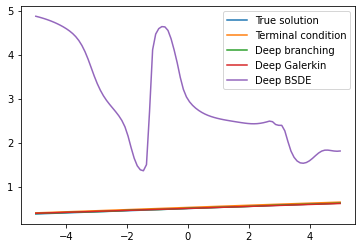

In [14]:
T=0.10
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 108 seconds; L1 error: 1.02E-02; L2 error: 1.86E-04; rel error: 2.08E-02.
fdb runtime: 137 seconds; total runtime: 245 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 334 seconds; L1 error: 2.46E-03; L2 error: 7.54E-06; rel error: 5.39E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 146 seconds; L1 error: 1.40E+01; L2 error: 2.05E+02; rel error: 2.90E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 1.00E-02; L2 error: 1.60E-04; rel error: 2.12E-02.
fdb runtime: 104 seconds; total runtime: 219 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 334 seconds; L1 error: 4.03E-03; L2 error: 1.89E-05; rel error: 8.71E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 145 seconds; L1 error: 7.71E+00; L2 error: 7.75E+01; rel error: 1.69E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 9.63E-03; L2 error: 1.47E-04; rel error: 1.98E-02.
fdb runtime: 109 seconds; total runtime: 232 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 321 seconds; L1 error: 4.70E-04; L2 error: 3.28E-07; rel error: 1.04E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 139 seconds; L1 error: 1.51E+01; L2 error: 2.34E+02; rel error: 3.07E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 125 seconds; L1 error: 8.93E-03; L2 error: 1.38E-04; rel error: 1.92E-02.
fdb runtime: 167 seconds; total runtime: 292 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 334 seconds; L1 error: 2.19E-03; L2 error: 8.73E-06; rel error: 5.06E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 150 seconds; L1 error: 1.77E+01; L2 error: 3.15E+02; rel error: 3.64E+01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 122 seconds; L1 error: 8.18E-03; L2 error: 1.10E-04; rel error: 1.79E-02.
fdb runtime: 254 seconds; total runtime: 376 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 339 seconds; L1 error: 1.03E-03; L2 error: 1.17E-06; rel error: 2.14E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 148 seconds; L1 error: 1.90E+01; L2 error: 3.68E+02; rel error: 3.90E+01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 7.76E-03; L2 error: 9.26E-05; rel error: 1.66E-02.
fdb runtime: 121 seconds; total runtime: 237 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 331 seconds; L1 error: 4.48E-03; L2 error: 3.48E-05; rel error: 1.03E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 141 seconds; L1 error: 6.52E+00; L2 error: 4.94E+01; rel error: 1.35E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 7.42E-03; L2 error: 9.26E-05; rel error: 1.63E-02.
fdb runtime: 116 seconds; total runtime: 233 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 315 seconds; L1 error: 1.59E-03; L2 error: 3.39E-06; rel error: 3.22E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 146 seconds; L1 error: 1.45E+01; L2 error: 2.24E+02; rel error: 3.05E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 8.23E-03; L2 error: 1.14E-04; rel error: 1.76E-02.
fdb runtime: 113 seconds; total runtime: 223 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 333 seconds; L1 error: 4.89E-03; L2 error: 3.00E-05; rel error: 1.07E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 148 seconds; L1 error: 7.54E+00; L2 error: 5.99E+01; rel error: 1.58E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 8.06E-03; L2 error: 9.70E-05; rel error: 1.71E-02.
fdb runtime: 170 seconds; total runtime: 291 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 344 seconds; L1 error: 8.90E-04; L2 error: 1.45E-06; rel error: 2.06E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 145 seconds; L1 error: 7.46E+00; L2 error: 5.75E+01; rel error: 1.52E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 124 seconds; L1 error: 6.27E-03; L2 error: 5.45E-05; rel error: 1.26E-02.
fdb runtime: 148 seconds; total runtime: 272 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 332 seconds; L1 error: 4.83E-02; L2 error: 3.22E-03; rel error: 1.05E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 145 seconds; L1 error: 1.10E+01; L2 error: 1.27E+02; rel error: 2.25E+01.




######## Summary for deep branching method
runtime:        118
fdb runtime:    144
total runtime:  262
mean L1 error:  8.47E-03
std L1 error:   1.17E-03
mean L2 error:  1.19E-04
std L2 error:   3.67E-05
mean rel error: 1.79E-02
std rel error:  2.41E-03


######## Summary for deep galerkin method
runtime:        332
mean L1 error:  7.03E-03
std L1 error:   1.38E-02
mean L2 error:  3.32E-04
std L2 error:   9.62E-04
mean rel error: 1.53E-02
std rel error:  3.00E-02


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  1.21E+01


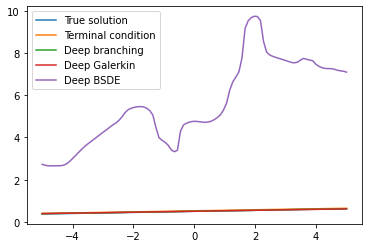

In [15]:
T=0.125
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 114 seconds; L1 error: 1.29E-02; L2 error: 3.64E-04; rel error: 2.57E-02.
fdb runtime: 135 seconds; total runtime: 249 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 331 seconds; L1 error: 3.72E-03; L2 error: 1.55E-05; rel error: 7.99E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 146 seconds; L1 error: 9.96E-01; L2 error: 1.41E+00; rel error: 1.98E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 1.47E-02; L2 error: 3.37E-04; rel error: 3.12E-02.
fdb runtime: 103 seconds; total runtime: 220 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 330 seconds; L1 error: 6.05E-03; L2 error: 3.94E-05; rel error: 1.28E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 145 seconds; L1 error: 1.52E+00; L2 error: 2.74E+00; rel error: 3.12E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 1.47E-02; L2 error: 3.07E-04; rel error: 3.06E-02.
fdb runtime: 111 seconds; total runtime: 228 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 335 seconds; L1 error: 4.78E-04; L2 error: 3.85E-07; rel error: 1.08E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 142 seconds; L1 error: 1.64E+01; L2 error: 3.53E+02; rel error: 3.57E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 126 seconds; L1 error: 1.51E-02; L2 error: 3.66E-04; rel error: 3.15E-02.
fdb runtime: 169 seconds; total runtime: 295 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 317 seconds; L1 error: 3.91E-03; L2 error: 1.96E-05; rel error: 8.61E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 137 seconds; L1 error: 1.59E+01; L2 error: 2.58E+02; rel error: 3.23E+01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 1.05E-02; L2 error: 1.98E-04; rel error: 2.33E-02.
fdb runtime: 265 seconds; total runtime: 384 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 331 seconds; L1 error: 1.18E-03; L2 error: 1.49E-06; rel error: 2.45E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 143 seconds; L1 error: 1.45E+01; L2 error: 2.24E+02; rel error: 2.92E+01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 113 seconds; L1 error: 9.69E-03; L2 error: 1.49E-04; rel error: 2.04E-02.
fdb runtime: 123 seconds; total runtime: 236 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 336 seconds; L1 error: 5.62E-03; L2 error: 5.06E-05; rel error: 1.28E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 138 seconds; L1 error: 1.70E+01; L2 error: 3.03E+02; rel error: 3.43E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 1.00E-02; L2 error: 1.79E-04; rel error: 2.21E-02.
fdb runtime: 116 seconds; total runtime: 233 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 337 seconds; L1 error: 1.72E-03; L2 error: 3.78E-06; rel error: 3.64E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 144 seconds; L1 error: 7.56E+00; L2 error: 5.93E+01; rel error: 1.58E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 9.92E-03; L2 error: 1.69E-04; rel error: 2.07E-02.
fdb runtime: 116 seconds; total runtime: 225 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 337 seconds; L1 error: 6.99E-03; L2 error: 5.52E-05; rel error: 1.50E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 145 seconds; L1 error: 1.90E+01; L2 error: 3.69E+02; rel error: 3.83E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 122 seconds; L1 error: 1.11E-02; L2 error: 1.61E-04; rel error: 2.35E-02.
fdb runtime: 164 seconds; total runtime: 286 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 319 seconds; L1 error: 1.37E-03; L2 error: 2.59E-06; rel error: 3.04E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 148 seconds; L1 error: 2.54E+01; L2 error: 6.74E+02; rel error: 5.23E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 6.72E-03; L2 error: 5.65E-05; rel error: 1.36E-02.
fdb runtime: 147 seconds; total runtime: 267 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 326 seconds; L1 error: 4.93E-02; L2 error: 3.39E-03; rel error: 1.08E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 143 seconds; L1 error: 2.65E+00; L2 error: 8.02E+00; rel error: 5.51E+00.




######## Summary for deep branching method
runtime:        117
fdb runtime:    145
total runtime:  262
mean L1 error:  1.15E-02
std L1 error:   2.59E-03
mean L2 error:  2.29E-04
std L2 error:   1.01E-04
mean rel error: 2.43E-02
std rel error:  5.39E-03


######## Summary for deep galerkin method
runtime:        330
mean L1 error:  8.03E-03
std L1 error:   1.39E-02
mean L2 error:  3.58E-04
std L2 error:   1.01E-03
mean rel error: 1.75E-02
std rel error:  3.04E-02


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  1.21E+01


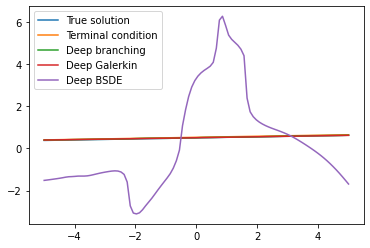

In [16]:
T=0.150
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 1.31E-02; L2 error: 2.79E-04; rel error: 2.64E-02.
fdb runtime: 133 seconds; total runtime: 243 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 333 seconds; L1 error: 5.12E-03; L2 error: 2.80E-05; rel error: 1.09E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 144 seconds; L1 error: 9.80E+00; L2 error: 9.97E+01; rel error: 1.99E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 1.62E-02; L2 error: 3.94E-04; rel error: 3.39E-02.
fdb runtime: 102 seconds; total runtime: 219 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 332 seconds; L1 error: 8.08E-03; L2 error: 6.81E-05; rel error: 1.70E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 146 seconds; L1 error: 7.58E+00; L2 error: 5.97E+01; rel error: 1.52E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 124 seconds; L1 error: 1.51E-02; L2 error: 3.29E-04; rel error: 3.24E-02.
fdb runtime: 109 seconds; total runtime: 232 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 338 seconds; L1 error: 5.29E-04; L2 error: 5.63E-07; rel error: 1.23E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 138 seconds; L1 error: 4.23E+00; L2 error: 1.95E+01; rel error: 8.34E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 1.66E-02; L2 error: 4.56E-04; rel error: 3.63E-02.
fdb runtime: 167 seconds; total runtime: 287 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 326 seconds; L1 error: 5.82E-03; L2 error: 3.85E-05; rel error: 1.25E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 140 seconds; L1 error: 4.77E+00; L2 error: 2.68E+01; rel error: 9.57E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 1.01E-02; L2 error: 2.22E-04; rel error: 2.21E-02.
fdb runtime: 259 seconds; total runtime: 377 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 335 seconds; L1 error: 1.33E-03; L2 error: 1.87E-06; rel error: 2.76E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 147 seconds; L1 error: 5.25E+00; L2 error: 3.76E+01; rel error: 9.96E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 1.32E-02; L2 error: 2.91E-04; rel error: 2.82E-02.
fdb runtime: 124 seconds; total runtime: 240 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 336 seconds; L1 error: 7.38E-03; L2 error: 7.47E-05; rel error: 1.64E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 146 seconds; L1 error: 7.06E+00; L2 error: 5.15E+01; rel error: 1.43E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 1.09E-02; L2 error: 2.86E-04; rel error: 2.31E-02.
fdb runtime: 116 seconds; total runtime: 237 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 334 seconds; L1 error: 1.99E-03; L2 error: 5.31E-06; rel error: 4.37E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 134 seconds; L1 error: 1.46E+01; L2 error: 2.23E+02; rel error: 2.94E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 1.16E-02; L2 error: 2.67E-04; rel error: 2.45E-02.
fdb runtime: 117 seconds; total runtime: 228 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 339 seconds; L1 error: 9.15E-03; L2 error: 9.04E-05; rel error: 1.95E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 144 seconds; L1 error: 7.79E+00; L2 error: 6.54E+01; rel error: 1.57E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 1.23E-02; L2 error: 2.37E-04; rel error: 2.58E-02.
fdb runtime: 166 seconds; total runtime: 286 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 331 seconds; L1 error: 2.02E-03; L2 error: 4.85E-06; rel error: 4.38E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 145 seconds; L1 error: 1.13E+01; L2 error: 1.30E+02; rel error: 2.31E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 1.08E-02; L2 error: 2.03E-04; rel error: 2.21E-02.
fdb runtime: 146 seconds; total runtime: 266 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 332 seconds; L1 error: 5.04E-02; L2 error: 3.61E-03; rel error: 1.11E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 145 seconds; L1 error: 1.38E+01; L2 error: 1.96E+02; rel error: 2.81E+01.




######## Summary for deep branching method
runtime:        118
fdb runtime:    144
total runtime:  262
mean L1 error:  1.30E-02
std L1 error:   2.19E-03
mean L2 error:  2.96E-04
std L2 error:   7.42E-05
mean rel error: 2.75E-02
std rel error:  4.82E-03


######## Summary for deep galerkin method
runtime:        334
mean L1 error:  9.19E-03
std L1 error:   1.40E-02
mean L2 error:  3.92E-04
std L2 error:   1.07E-03
mean rel error: 2.00E-02
std rel error:  3.09E-02


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  8.62E+00


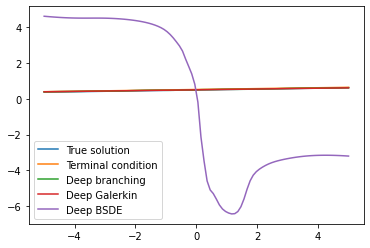

In [17]:
T=0.175
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 114 seconds; L1 error: 1.29E-02; L2 error: 2.72E-04; rel error: 2.73E-02.
fdb runtime: 140 seconds; total runtime: 254 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 345 seconds; L1 error: 6.66E-03; L2 error: 4.63E-05; rel error: 1.40E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 143 seconds; L1 error: 5.71E+00; L2 error: 3.82E+01; rel error: 1.23E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 1.78E-02; L2 error: 5.93E-04; rel error: 3.93E-02.
fdb runtime: 102 seconds; total runtime: 212 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 335 seconds; L1 error: 1.01E-02; L2 error: 1.06E-04; rel error: 2.12E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 138 seconds; L1 error: 3.52E+00; L2 error: 1.45E+01; rel error: 6.83E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 1.54E-02; L2 error: 3.94E-04; rel error: 3.36E-02.
fdb runtime: 110 seconds; total runtime: 230 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 314 seconds; L1 error: 7.70E-04; L2 error: 1.03E-06; rel error: 1.76E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 137 seconds; L1 error: 1.28E+01; L2 error: 1.71E+02; rel error: 2.55E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 114 seconds; L1 error: 1.77E-02; L2 error: 4.78E-04; rel error: 3.85E-02.
fdb runtime: 172 seconds; total runtime: 286 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 311 seconds; L1 error: 7.93E-03; L2 error: 6.80E-05; rel error: 1.69E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 142 seconds; L1 error: 3.58E+00; L2 error: 1.56E+01; rel error: 6.89E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 115 seconds; L1 error: 1.30E-02; L2 error: 3.29E-04; rel error: 2.84E-02.
fdb runtime: 259 seconds; total runtime: 374 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 302 seconds; L1 error: 1.50E-03; L2 error: 2.36E-06; rel error: 3.11E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 151 seconds; L1 error: 8.60E+00; L2 error: 7.74E+01; rel error: 1.79E+01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 108 seconds; L1 error: 1.59E-02; L2 error: 4.23E-04; rel error: 3.41E-02.
fdb runtime: 122 seconds; total runtime: 230 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 329 seconds; L1 error: 9.43E-03; L2 error: 1.10E-04; rel error: 2.07E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 150 seconds; L1 error: 1.05E+01; L2 error: 1.16E+02; rel error: 2.10E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 114 seconds; L1 error: 1.18E-02; L2 error: 1.89E-04; rel error: 2.46E-02.
fdb runtime: 113 seconds; total runtime: 227 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 335 seconds; L1 error: 2.42E-03; L2 error: 8.17E-06; rel error: 5.39E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 143 seconds; L1 error: 8.09E+00; L2 error: 7.95E+01; rel error: 1.66E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 108 seconds; L1 error: 1.30E-02; L2 error: 3.24E-04; rel error: 2.72E-02.
fdb runtime: 114 seconds; total runtime: 222 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 320 seconds; L1 error: 1.14E-02; L2 error: 1.36E-04; rel error: 2.40E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 147 seconds; L1 error: 5.77E+00; L2 error: 3.71E+01; rel error: 1.22E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 1.44E-02; L2 error: 3.70E-04; rel error: 3.07E-02.
fdb runtime: 164 seconds; total runtime: 284 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 332 seconds; L1 error: 2.84E-03; L2 error: 8.94E-06; rel error: 6.08E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 137 seconds; L1 error: 7.41E+00; L2 error: 6.03E+01; rel error: 1.50E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 1.48E-02; L2 error: 3.08E-04; rel error: 3.03E-02.
fdb runtime: 147 seconds; total runtime: 263 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 323 seconds; L1 error: 5.19E-02; L2 error: 3.88E-03; rel error: 1.15E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 145 seconds; L1 error: 9.06E+00; L2 error: 8.60E+01; rel error: 1.85E+01.




######## Summary for deep branching method
runtime:        114
fdb runtime:    144
total runtime:  258
mean L1 error:  1.47E-02
std L1 error:   1.94E-03
mean L2 error:  3.68E-04
std L2 error:   1.07E-04
mean rel error: 3.14E-02
std rel error:  4.66E-03


######## Summary for deep galerkin method
runtime:        325
mean L1 error:  1.05E-02
std L1 error:   1.43E-02
mean L2 error:  4.36E-04
std L2 error:   1.15E-03
mean rel error: 2.28E-02
std rel error:  3.16E-02


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  7.51E+00


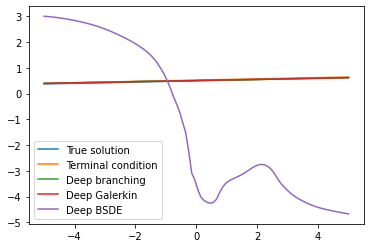

In [18]:
T=0.2
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 112 seconds; L1 error: 1.72E-02; L2 error: 3.88E-04; rel error: 3.65E-02.
fdb runtime: 139 seconds; total runtime: 251 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 324 seconds; L1 error: 1.02E-02; L2 error: 1.06E-04; rel error: 2.13E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 140 seconds; L1 error: 5.27E+00; L2 error: 2.88E+01; rel error: 1.06E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 2.25E-02; L2 error: 1.11E-03; rel error: 4.98E-02.
fdb runtime: 110 seconds; total runtime: 229 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 331 seconds; L1 error: 1.44E-02; L2 error: 2.11E-04; rel error: 3.00E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 138 seconds; L1 error: 7.33E+00; L2 error: 6.57E+01; rel error: 1.40E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 1.29E-02; L2 error: 2.40E-04; rel error: 2.70E-02.
fdb runtime: 116 seconds; total runtime: 238 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 332 seconds; L1 error: 1.82E-03; L2 error: 3.90E-06; rel error: 3.93E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 137 seconds; L1 error: 5.06E+00; L2 error: 4.15E+01; rel error: 9.43E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 122 seconds; L1 error: 2.62E-02; L2 error: 1.13E-03; rel error: 5.76E-02.
fdb runtime: 174 seconds; total runtime: 296 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 329 seconds; L1 error: 1.29E-02; L2 error: 1.72E-04; rel error: 2.70E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 143 seconds; L1 error: 6.48E+00; L2 error: 5.05E+01; rel error: 1.34E+01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 1.68E-02; L2 error: 4.94E-04; rel error: 3.59E-02.
fdb runtime: 260 seconds; total runtime: 378 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 326 seconds; L1 error: 1.95E-03; L2 error: 3.90E-06; rel error: 4.03E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 145 seconds; L1 error: 3.50E+00; L2 error: 1.50E+01; rel error: 6.90E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 114 seconds; L1 error: 2.14E-02; L2 error: 7.62E-04; rel error: 4.68E-02.
fdb runtime: 126 seconds; total runtime: 240 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 338 seconds; L1 error: 1.44E-02; L2 error: 2.32E-04; rel error: 3.10E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 151 seconds; L1 error: 3.47E+00; L2 error: 2.03E+01; rel error: 7.71E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 124 seconds; L1 error: 1.31E-02; L2 error: 2.89E-04; rel error: 2.81E-02.
fdb runtime: 116 seconds; total runtime: 240 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 333 seconds; L1 error: 3.99E-03; L2 error: 2.00E-05; rel error: 8.74E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 150 seconds; L1 error: 8.31E+00; L2 error: 7.10E+01; rel error: 1.69E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 1.75E-02; L2 error: 5.22E-04; rel error: 3.94E-02.
fdb runtime: 114 seconds; total runtime: 230 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 321 seconds; L1 error: 1.60E-02; L2 error: 2.64E-04; rel error: 3.36E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 147 seconds; L1 error: 7.47E+00; L2 error: 6.85E+01; rel error: 1.62E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 2.35E-02; L2 error: 1.62E-03; rel error: 4.99E-02.
fdb runtime: 163 seconds; total runtime: 286 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 316 seconds; L1 error: 5.09E-03; L2 error: 2.69E-05; rel error: 1.07E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 146 seconds; L1 error: 1.31E+00; L2 error: 1.94E+00; rel error: 2.63E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 1.47E-02; L2 error: 5.75E-04; rel error: 3.16E-02.
fdb runtime: 148 seconds; total runtime: 264 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 332 seconds; L1 error: 5.55E-02; L2 error: 4.55E-03; rel error: 1.24E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 148 seconds; L1 error: 2.62E+00; L2 error: 7.40E+00; rel error: 5.32E+00.




######## Summary for deep branching method
runtime:        119
fdb runtime:    147
total runtime:  265
mean L1 error:  1.86E-02
std L1 error:   4.37E-03
mean L2 error:  7.14E-04
std L2 error:   4.21E-04
mean rel error: 4.03E-02
std rel error:  9.79E-03


######## Summary for deep galerkin method
runtime:        328
mean L1 error:  1.36E-02
std L1 error:   1.49E-02
mean L2 error:  5.59E-04
std L2 error:   1.33E-03
mean rel error: 2.94E-02
std rel error:  3.33E-02


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  5.08E+00


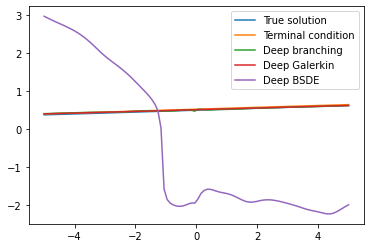

In [8]:
T=0.25
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 114 seconds; L1 error: 1.91E-02; L2 error: 5.63E-04; rel error: 4.10E-02.
fdb runtime: 139 seconds; total runtime: 253 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 328 seconds; L1 error: 1.44E-02; L2 error: 2.09E-04; rel error: 2.99E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 146 seconds; L1 error: 6.73E+00; L2 error: 4.87E+01; rel error: 1.36E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 1.87E-02; L2 error: 7.16E-04; rel error: 4.29E-02.
fdb runtime: 106 seconds; total runtime: 227 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 327 seconds; L1 error: 1.90E-02; L2 error: 3.64E-04; rel error: 3.94E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 147 seconds; L1 error: 9.42E+00; L2 error: 1.18E+02; rel error: 1.89E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 1.49E-02; L2 error: 4.13E-04; rel error: 3.36E-02.
fdb runtime: 117 seconds; total runtime: 237 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 325 seconds; L1 error: 3.38E-03; L2 error: 1.23E-05; rel error: 7.18E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 6.99E+00; L2 error: 5.18E+01; rel error: 1.42E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 2.44E-02; L2 error: 1.02E-03; rel error: 5.44E-02.
fdb runtime: 174 seconds; total runtime: 297 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 328 seconds; L1 error: 1.89E-02; L2 error: 3.66E-04; rel error: 3.95E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 146 seconds; L1 error: 2.68E+00; L2 error: 1.41E+01; rel error: 4.92E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 122 seconds; L1 error: 2.02E-02; L2 error: 6.30E-04; rel error: 4.44E-02.
fdb runtime: 272 seconds; total runtime: 394 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 321 seconds; L1 error: 2.63E-03; L2 error: 7.02E-06; rel error: 5.43E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 137 seconds; L1 error: 2.25E+00; L2 error: 6.11E+00; rel error: 4.56E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 113 seconds; L1 error: 2.30E-02; L2 error: 8.09E-04; rel error: 4.92E-02.
fdb runtime: 122 seconds; total runtime: 235 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 327 seconds; L1 error: 2.07E-02; L2 error: 4.54E-04; rel error: 4.38E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 146 seconds; L1 error: 1.13E+01; L2 error: 1.31E+02; rel error: 2.33E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 112 seconds; L1 error: 1.59E-02; L2 error: 4.42E-04; rel error: 3.60E-02.
fdb runtime: 121 seconds; total runtime: 233 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 319 seconds; L1 error: 6.38E-03; L2 error: 4.53E-05; rel error: 1.37E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 148 seconds; L1 error: 4.36E+00; L2 error: 2.30E+01; rel error: 9.30E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 109 seconds; L1 error: 2.02E-02; L2 error: 5.44E-04; rel error: 4.33E-02.
fdb runtime: 114 seconds; total runtime: 223 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 336 seconds; L1 error: 2.09E-02; L2 error: 4.47E-04; rel error: 4.36E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 149 seconds; L1 error: 7.03E+00; L2 error: 5.25E+01; rel error: 1.46E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 1.79E-02; L2 error: 4.75E-04; rel error: 3.90E-02.
fdb runtime: 164 seconds; total runtime: 287 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 333 seconds; L1 error: 8.24E-03; L2 error: 6.91E-05; rel error: 1.72E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 149 seconds; L1 error: 2.12E+00; L2 error: 6.79E+00; rel error: 4.48E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 1.55E-02; L2 error: 4.37E-04; rel error: 3.52E-02.
fdb runtime: 146 seconds; total runtime: 264 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 340 seconds; L1 error: 6.03E-02; L2 error: 5.45E-03; rel error: 1.36E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 140 seconds; L1 error: 4.92E+00; L2 error: 3.05E+01; rel error: 1.03E+01.




######## Summary for deep branching method
runtime:        118
fdb runtime:    147
total runtime:  265
mean L1 error:  1.90E-02
std L1 error:   2.98E-03
mean L2 error:  6.05E-04
std L2 error:   1.84E-04
mean rel error: 4.19E-02
std rel error:  6.14E-03


######## Summary for deep galerkin method
runtime:        328
mean L1 error:  1.75E-02
std L1 error:   1.58E-02
mean L2 error:  7.42E-04
std L2 error:   1.58E-03
mean rel error: 3.75E-02
std rel error:  3.56E-02


######## Summary for deep BSDE method
runtime:        146
mean L1 error:  5.78E+00


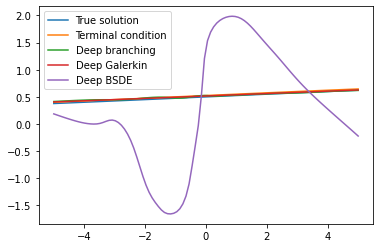

In [9]:
T=0.30
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 108 seconds; L1 error: 1.70E-02; L2 error: 4.38E-04; rel error: 3.66E-02.
fdb runtime: 135 seconds; total runtime: 243 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 336 seconds; L1 error: 1.93E-02; L2 error: 3.75E-04; rel error: 4.00E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 148 seconds; L1 error: 3.11E+00; L2 error: 1.28E+01; rel error: 6.61E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 2.41E-02; L2 error: 1.13E-03; rel error: 5.51E-02.
fdb runtime: 104 seconds; total runtime: 220 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 342 seconds; L1 error: 2.40E-02; L2 error: 5.80E-04; rel error: 4.96E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 149 seconds; L1 error: 3.92E+00; L2 error: 2.22E+01; rel error: 7.74E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 125 seconds; L1 error: 1.51E-02; L2 error: 3.62E-04; rel error: 3.37E-02.
fdb runtime: 111 seconds; total runtime: 236 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 337 seconds; L1 error: 5.55E-03; L2 error: 3.20E-05; rel error: 1.17E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 8.10E+00; L2 error: 7.31E+01; rel error: 1.67E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 129 seconds; L1 error: 2.59E-02; L2 error: 1.18E-03; rel error: 5.80E-02.
fdb runtime: 168 seconds; total runtime: 297 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 343 seconds; L1 error: 2.62E-02; L2 error: 6.98E-04; rel error: 5.45E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 149 seconds; L1 error: 1.79E+00; L2 error: 4.24E+00; rel error: 3.68E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 122 seconds; L1 error: 2.12E-02; L2 error: 6.51E-04; rel error: 4.66E-02.
fdb runtime: 258 seconds; total runtime: 379 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 330 seconds; L1 error: 3.68E-03; L2 error: 1.37E-05; rel error: 7.59E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 150 seconds; L1 error: 5.45E+00; L2 error: 3.33E+01; rel error: 1.10E+01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 2.55E-02; L2 error: 9.35E-04; rel error: 5.51E-02.
fdb runtime: 122 seconds; total runtime: 243 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 335 seconds; L1 error: 2.82E-02; L2 error: 8.23E-04; rel error: 5.92E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 145 seconds; L1 error: 6.37E+00; L2 error: 4.37E+01; rel error: 1.33E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 117 seconds; L1 error: 2.16E-02; L2 error: 7.33E-04; rel error: 4.86E-02.
fdb runtime: 116 seconds; total runtime: 233 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 342 seconds; L1 error: 9.40E-03; L2 error: 9.36E-05; rel error: 1.99E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 150 seconds; L1 error: 2.38E+00; L2 error: 8.66E+00; rel error: 4.78E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 2.43E-02; L2 error: 9.74E-04; rel error: 5.44E-02.
fdb runtime: 115 seconds; total runtime: 225 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 333 seconds; L1 error: 2.61E-02; L2 error: 6.93E-04; rel error: 5.43E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 149 seconds; L1 error: 5.64E+00; L2 error: 4.82E+01; rel error: 1.09E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 2.11E-02; L2 error: 6.89E-04; rel error: 4.61E-02.
fdb runtime: 164 seconds; total runtime: 282 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 334 seconds; L1 error: 1.25E-02; L2 error: 1.57E-04; rel error: 2.59E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 145 seconds; L1 error: 5.22E+00; L2 error: 2.93E+01; rel error: 1.08E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 1.86E-02; L2 error: 5.26E-04; rel error: 4.18E-02.
fdb runtime: 147 seconds; total runtime: 267 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 330 seconds; L1 error: 6.63E-02; L2 error: 6.57E-03; rel error: 1.49E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 145 seconds; L1 error: 6.86E+00; L2 error: 5.14E+01; rel error: 1.41E+01.




######## Summary for deep branching method
runtime:        118
fdb runtime:    144
total runtime:  263
mean L1 error:  2.14E-02
std L1 error:   3.45E-03
mean L2 error:  7.61E-04
std L2 error:   2.69E-04
mean rel error: 4.76E-02
std rel error:  7.87E-03


######## Summary for deep galerkin method
runtime:        336
mean L1 error:  2.21E-02
std L1 error:   1.70E-02
mean L2 error:  1.00E-03
std L2 error:   1.88E-03
mean rel error: 4.72E-02
std rel error:  3.84E-02


######## Summary for deep BSDE method
runtime:        148
mean L1 error:  4.88E+00


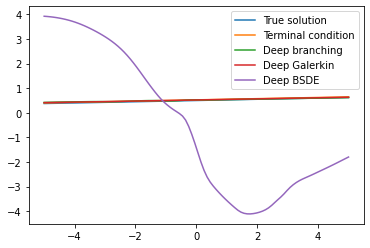

In [10]:
T=0.35
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 1.72E-02; L2 error: 4.75E-04; rel error: 3.81E-02.
fdb runtime: 135 seconds; total runtime: 245 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 334 seconds; L1 error: 2.50E-02; L2 error: 6.30E-04; rel error: 5.17E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 151 seconds; L1 error: 1.74E+00; L2 error: 4.26E+00; rel error: 3.85E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 2.37E-02; L2 error: 1.03E-03; rel error: 5.26E-02.
fdb runtime: 104 seconds; total runtime: 227 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 343 seconds; L1 error: 2.94E-02; L2 error: 8.70E-04; rel error: 6.08E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 146 seconds; L1 error: 3.78E+00; L2 error: 1.78E+01; rel error: 8.13E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 124 seconds; L1 error: 2.03E-02; L2 error: 6.13E-04; rel error: 4.55E-02.
fdb runtime: 111 seconds; total runtime: 235 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 338 seconds; L1 error: 8.62E-03; L2 error: 7.60E-05; rel error: 1.80E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 149 seconds; L1 error: 4.45E+00; L2 error: 2.12E+01; rel error: 9.28E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 2.40E-02; L2 error: 9.73E-04; rel error: 5.27E-02.
fdb runtime: 168 seconds; total runtime: 288 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 342 seconds; L1 error: 3.49E-02; L2 error: 1.23E-03; rel error: 7.24E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 149 seconds; L1 error: 1.83E+00; L2 error: 4.18E+00; rel error: 3.79E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 2.26E-02; L2 error: 7.46E-04; rel error: 4.93E-02.
fdb runtime: 258 seconds; total runtime: 381 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 336 seconds; L1 error: 5.24E-03; L2 error: 2.77E-05; rel error: 1.08E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 148 seconds; L1 error: 3.35E+00; L2 error: 1.26E+01; rel error: 7.11E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 112 seconds; L1 error: 2.46E-02; L2 error: 1.03E-03; rel error: 5.42E-02.
fdb runtime: 122 seconds; total runtime: 234 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 342 seconds; L1 error: 3.67E-02; L2 error: 1.38E-03; rel error: 7.68E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 150 seconds; L1 error: 1.34E+01; L2 error: 1.87E+02; rel error: 2.75E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 2.15E-02; L2 error: 6.21E-04; rel error: 4.72E-02.
fdb runtime: 116 seconds; total runtime: 239 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 350 seconds; L1 error: 1.32E-02; L2 error: 1.80E-04; rel error: 2.77E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 150 seconds; L1 error: 3.68E+00; L2 error: 2.17E+01; rel error: 6.86E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 2.30E-02; L2 error: 7.86E-04; rel error: 5.06E-02.
fdb runtime: 116 seconds; total runtime: 231 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 334 seconds; L1 error: 3.16E-02; L2 error: 1.01E-03; rel error: 6.56E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 147 seconds; L1 error: 3.32E+00; L2 error: 1.47E+01; rel error: 7.25E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 2.19E-02; L2 error: 7.43E-04; rel error: 4.80E-02.
fdb runtime: 165 seconds; total runtime: 288 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 328 seconds; L1 error: 1.80E-02; L2 error: 3.25E-04; rel error: 3.71E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 147 seconds; L1 error: 1.86E+00; L2 error: 5.88E+00; rel error: 3.74E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 116 seconds; L1 error: 2.15E-02; L2 error: 7.30E-04; rel error: 4.86E-02.
fdb runtime: 147 seconds; total runtime: 263 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 336 seconds; L1 error: 7.34E-02; L2 error: 7.90E-03; rel error: 1.65E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 149 seconds; L1 error: 3.10E+00; L2 error: 1.44E+01; rel error: 6.94E+00.




######## Summary for deep branching method
runtime:        119
fdb runtime:    144
total runtime:  263
mean L1 error:  2.20E-02
std L1 error:   2.02E-03
mean L2 error:  7.75E-04
std L2 error:   1.77E-04
mean rel error: 4.87E-02
std rel error:  4.35E-03


######## Summary for deep galerkin method
runtime:        338
mean L1 error:  2.76E-02
std L1 error:   1.85E-02
mean L2 error:  1.36E-03
std L2 error:   2.23E-03
mean rel error: 5.86E-02
std rel error:  4.16E-02


######## Summary for deep BSDE method
runtime:        149
mean L1 error:  4.05E+00


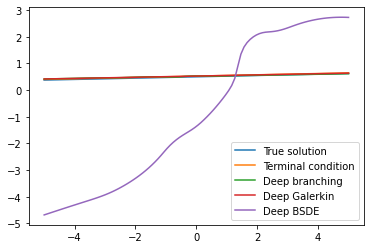

In [11]:
T=0.40
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 115 seconds; L1 error: 2.09E-02; L2 error: 6.90E-04; rel error: 4.67E-02.
fdb runtime: 135 seconds; total runtime: 250 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 327 seconds; L1 error: 3.16E-02; L2 error: 1.01E-03; rel error: 6.53E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 150 seconds; L1 error: 5.97E+00; L2 error: 3.79E+01; rel error: 1.25E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 114 seconds; L1 error: 2.41E-02; L2 error: 8.66E-04; rel error: 5.32E-02.
fdb runtime: 104 seconds; total runtime: 218 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 340 seconds; L1 error: 3.54E-02; L2 error: 1.26E-03; rel error: 7.31E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 149 seconds; L1 error: 5.65E+00; L2 error: 3.81E+01; rel error: 1.16E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 112 seconds; L1 error: 2.22E-02; L2 error: 7.35E-04; rel error: 4.97E-02.
fdb runtime: 111 seconds; total runtime: 222 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 327 seconds; L1 error: 1.28E-02; L2 error: 1.66E-04; rel error: 2.66E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 134 seconds; L1 error: 1.17E+01; L2 error: 1.44E+02; rel error: 2.44E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 118 seconds; L1 error: 2.81E-02; L2 error: 1.27E-03; rel error: 6.23E-02.
fdb runtime: 168 seconds; total runtime: 287 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 328 seconds; L1 error: 4.48E-02; L2 error: 2.03E-03; rel error: 9.28E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 148 seconds; L1 error: 4.37E+00; L2 error: 2.39E+01; rel error: 8.63E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 2.45E-02; L2 error: 8.24E-04; rel error: 5.34E-02.
fdb runtime: 256 seconds; total runtime: 379 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 332 seconds; L1 error: 7.47E-03; L2 error: 5.61E-05; rel error: 1.54E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 147 seconds; L1 error: 9.81E+00; L2 error: 1.02E+02; rel error: 1.97E+01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 104 seconds; L1 error: 2.78E-02; L2 error: 1.27E-03; rel error: 6.08E-02.
fdb runtime: 122 seconds; total runtime: 226 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 301 seconds; L1 error: 4.62E-02; L2 error: 2.18E-03; rel error: 9.63E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 150 seconds; L1 error: 4.87E+00; L2 error: 2.84E+01; rel error: 1.04E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 119 seconds; L1 error: 2.46E-02; L2 error: 7.80E-04; rel error: 5.37E-02.
fdb runtime: 116 seconds; total runtime: 235 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 329 seconds; L1 error: 1.78E-02; L2 error: 3.24E-04; rel error: 3.72E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 138 seconds; L1 error: 7.58E+00; L2 error: 5.95E+01; rel error: 1.55E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 103 seconds; L1 error: 2.41E-02; L2 error: 9.49E-04; rel error: 5.37E-02.
fdb runtime: 115 seconds; total runtime: 218 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 331 seconds; L1 error: 3.73E-02; L2 error: 1.41E-03; rel error: 7.74E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 144 seconds; L1 error: 1.95E+00; L2 error: 4.56E+00; rel error: 3.78E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 127 seconds; L1 error: 2.39E-02; L2 error: 9.68E-04; rel error: 5.26E-02.
fdb runtime: 164 seconds; total runtime: 291 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 341 seconds; L1 error: 2.49E-02; L2 error: 6.20E-04; rel error: 5.13E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 148 seconds; L1 error: 3.65E+00; L2 error: 1.41E+01; rel error: 7.45E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 125 seconds; L1 error: 2.18E-02; L2 error: 7.46E-04; rel error: 4.92E-02.
fdb runtime: 146 seconds; total runtime: 271 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 321 seconds; L1 error: 8.14E-02; L2 error: 9.44E-03; rel error: 1.82E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 146 seconds; L1 error: 3.23E+00; L2 error: 1.14E+01; rel error: 6.63E+00.




######## Summary for deep branching method
runtime:        116
fdb runtime:    144
total runtime:  260
mean L1 error:  2.42E-02
std L1 error:   2.20E-03
mean L2 error:  9.10E-04
std L2 error:   1.99E-04
mean rel error: 5.35E-02
std rel error:  4.60E-03


######## Summary for deep galerkin method
runtime:        328
mean L1 error:  3.40E-02
std L1 error:   2.01E-02
mean L2 error:  1.85E-03
std L2 error:   2.62E-03
mean rel error: 7.18E-02
std rel error:  4.49E-02


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  5.88E+00


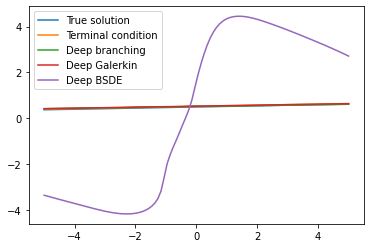

In [12]:
T=0.45
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 2.39E-02; L2 error: 7.90E-04; rel error: 5.26E-02.
fdb runtime: 135 seconds; total runtime: 245 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 340 seconds; L1 error: 3.92E-02; L2 error: 1.55E-03; rel error: 8.09E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 145 seconds; L1 error: 5.85E+00; L2 error: 3.59E+01; rel error: 1.20E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 120 seconds; L1 error: 2.43E-02; L2 error: 9.19E-04; rel error: 5.42E-02.
fdb runtime: 104 seconds; total runtime: 223 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 335 seconds; L1 error: 4.19E-02; L2 error: 1.77E-03; rel error: 8.65E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 150 seconds; L1 error: 1.61E+00; L2 error: 3.37E+00; rel error: 3.07E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 114 seconds; L1 error: 2.17E-02; L2 error: 8.16E-04; rel error: 4.94E-02.
fdb runtime: 111 seconds; total runtime: 225 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 324 seconds; L1 error: 1.82E-02; L2 error: 3.36E-04; rel error: 3.78E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 4.95E+00; L2 error: 2.81E+01; rel error: 1.01E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 125 seconds; L1 error: 2.67E-02; L2 error: 9.30E-04; rel error: 5.83E-02.
fdb runtime: 168 seconds; total runtime: 293 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 343 seconds; L1 error: 5.58E-02; L2 error: 3.14E-03; rel error: 1.15E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 150 seconds; L1 error: 1.67E+00; L2 error: 3.14E+00; rel error: 3.43E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 118 seconds; L1 error: 2.39E-02; L2 error: 8.53E-04; rel error: 5.29E-02.
fdb runtime: 256 seconds; total runtime: 374 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 342 seconds; L1 error: 1.05E-02; L2 error: 1.11E-04; rel error: 2.17E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 150 seconds; L1 error: 3.70E+00; L2 error: 1.59E+01; rel error: 7.48E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 112 seconds; L1 error: 3.07E-02; L2 error: 1.70E-03; rel error: 6.69E-02.
fdb runtime: 122 seconds; total runtime: 234 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 339 seconds; L1 error: 5.64E-02; L2 error: 3.23E-03; rel error: 1.17E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 150 seconds; L1 error: 1.52E+00; L2 error: 2.58E+00; rel error: 3.19E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 118 seconds; L1 error: 2.63E-02; L2 error: 9.19E-04; rel error: 5.79E-02.
fdb runtime: 116 seconds; total runtime: 234 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 336 seconds; L1 error: 2.34E-02; L2 error: 5.56E-04; rel error: 4.86E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 136 seconds; L1 error: 4.19E+00; L2 error: 2.13E+01; rel error: 8.26E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 98 seconds; L1 error: 2.68E-02; L2 error: 1.16E-03; rel error: 5.98E-02.
fdb runtime: 115 seconds; total runtime: 213 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 333 seconds; L1 error: 4.34E-02; L2 error: 1.90E-03; rel error: 8.98E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 147 seconds; L1 error: 1.18E+00; L2 error: 1.86E+00; rel error: 2.52E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 126 seconds; L1 error: 2.44E-02; L2 error: 9.46E-04; rel error: 5.43E-02.
fdb runtime: 164 seconds; total runtime: 291 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 342 seconds; L1 error: 3.32E-02; L2 error: 1.11E-03; rel error: 6.84E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 147 seconds; L1 error: 1.66E+00; L2 error: 4.47E+00; rel error: 3.19E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 121 seconds; L1 error: 2.38E-02; L2 error: 8.84E-04; rel error: 5.36E-02.
fdb runtime: 146 seconds; total runtime: 266 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 351 seconds; L1 error: 9.02E-02; L2 error: 1.12E-02; rel error: 2.01E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 147 seconds; L1 error: 5.10E+00; L2 error: 3.41E+01; rel error: 1.00E+01.




######## Summary for deep branching method
runtime:        116
fdb runtime:    144
total runtime:  260
mean L1 error:  2.52E-02
std L1 error:   2.35E-03
mean L2 error:  9.91E-04
std L2 error:   2.54E-04
mean rel error: 5.60E-02
std rel error:  4.67E-03


######## Summary for deep galerkin method
runtime:        338
mean L1 error:  4.12E-02
std L1 error:   2.17E-02
mean L2 error:  2.48E-03
std L2 error:   3.06E-03
mean rel error: 8.67E-02
std rel error:  4.82E-02


######## Summary for deep BSDE method
runtime:        147
mean L1 error:  3.14E+00


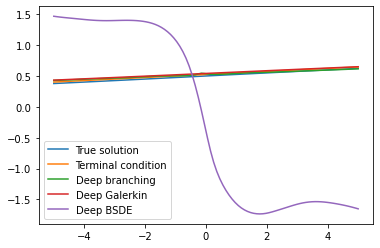

In [13]:
T=0.50
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)